## Description:
######Model type = RNN
######Hidden layers = 128*2
######train seq_len = 10
######model id = new-rnn128-10
######model_name feature and printing more
######want to try epoch down and batch size down, but should keep same for experiment between LSTM and RMM
chars = sorted(list(set(text)))

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import DataLoader
import torch.utils.data as data

import matplotlib.pyplot as plt
import numpy as np

Google Colab Mounting

In [30]:
#mount google drive on colab for saving pytorch model variables
from google.colab import drive
import os
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


Hyper Params

In [31]:
#data
seq_len = 10
batch_size = 50
#model:
hidden_size = 128
n_layers = 2
cell_type = "rnn"
#traininng:
n_epoch = 30
lr = 1e-4
dropout = 0.2
print_every = 1  #generate text per epoch
plot_every = 100 #calc accuracy/loss per 100 batch
#model/record saving/loading:
LOAD = False
data_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/data/shakespeare_train.txt"
model_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/model/"
rec_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/rec/"
model_id = 'new-' + cell_type + str(hidden_size) + '-' + str(seq_len) #save as 
load_model_name = None
rec_name = "rec-"+ model_id + ".pkl"
load_rec_name = "rec-"+ model_id + ".pkl"
print(model_id)

new-rnn128-10


Data Loading

In [32]:
import io
data_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/data/shakespeare_train.txt"
test_data_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/data/shakespeare_valid.txt"
model_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/model/"
with io.open(data_path, 'r', encoding = 'utf8') as f:
    text = f.read()
with io.open(test_data_path, 'r', encoding = 'utf8') as f:
    test_text = f.read()

chars = sorted(list(set(text))) #set will not be the same every time, which cause loss of model before new-rnn-128-200
tchars = sorted(list(set(test_text)))
char2int = {c:i for i,c in enumerate(chars)}
int2char = dict(enumerate(chars))
nptext = np.array([char2int[ch] for ch in text])
npttext = np.array([char2int[ch] for ch in test_text])

N = nptext.shape[0]
tN = npttext.shape[0]
Nc = len(chars)
tNc = len(tchars)
for ele in tchars:
    assert(ele in chars)
print("all elememts in test data is in train data")
print("total train data length = {}, there are {} kinds of character".format(N, Nc))
print("total test data length = {}, there are {} kinds of character".format(tN, tNc))
print(chars)

all elememts in test data is in train data
total train data length = 4351312, there are 67 kinds of character
total test data length = 222025, there are 62 kinds of character
['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Data Preprocessing

In [33]:
from typing import List, Union #python 3.8 requried
num = Union[int, float]
def chunks(arr, chunk_len):
    for i in range(0, len(arr) - chunk_len, chunk_len):
        yield arr[i:i + chunk_len]

def s2tensor(s: str, device: str) -> torch.LongTensor:
    return torch.Tensor([char2int[s[i]] if s[i] in char2int else 0 for i in range(len(s))]).long().to(device)

def tensor2s(t: torch.Tensor) -> str:
    val = t.cpu().detach().numpy()
    ret = "" 
    return ret.join([int2char[val[i]] for i in range(len(val))])

#preprocessing train data:
seqs = list(chunks(nptext, seq_len + 1))
batches = list(chunks(seqs, batch_size))
train_data = [torch.LongTensor(batch).transpose_(0, 1) for batch in batches] #.transpose_(0, 1) => not batch first
#shape = (#batch, seqlen+1atch, batch_size)
print(len(train_data), train_data[0].shape)

#preprocessing test data:
tseqs = list(chunks(npttext, seq_len + 1))
tbatches = list(chunks(tseqs, batch_size))
test_data = [torch.LongTensor(batch).transpose_(0, 1) for batch in tbatches] #.transpose_(0, 1) => not batch first
#shape = (#batch, seqlen+1atch, batch_size)
print(len(test_data), test_data[0].shape)
#rint(tensor2s(test_data[0].transpose_(0, 1)[0]))

7911 torch.Size([11, 50])
403 torch.Size([11, 50])


Model

In [0]:
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, cell_type="rnn", n_layers=2, drop_out=0.2):
        super(CharRNN, self).__init__()
        self.cell_type = cell_type.lower()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        if self.cell_type == "rnn":
            self.rnn = nn.RNN(hidden_size, hidden_size, n_layers, dropout=dropout)
        elif self.cell_type == "lstm":
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers, dropout=dropout)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded, hidden) #print(output.shape)
        output = self.decoder(output) #print(output.shape)
        return output, hidden
    def forwardc(self, input, hidden, device='cpu'): #for characters : torch([long]) to distribution
        input = input.view(1, 1).to(device) #batch = 1, len = 1 #need to be added:to(device)
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded, hidden)
        output = self.decoder(output)
        output = output.view(self.input_size)
        #print(output)
        return output, hidden

    def init_hidden(self, batch_size=batch_size, device='cpu'):
        if self.cell_type == "lstm":
            return (Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)),
                    Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)))
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device))

Generate Prediction with temparature


In [0]:
def generate(model, device='cpu', seed='Juliet', predict_len=300, tau=0.8): 
    seed_tensor = s2tensor(seed, device) #shape = torch.Size([seqlen])
    #generate hidden 
    h = model.init_hidden(batch_size=1, device=device)
    for x in seed_tensor:
        _, h = model.forwardc(x, h, device)
    #generate seq
    inc = seed_tensor[-1]
    ret = seed
    for i in range(predict_len):
        out, h =  model.forwardc(inc, h, device)
        if tau >= 0.2 :
            tau_distribution = out.detach().data.view(-1).div(tau).exp()
            predi = torch.multinomial(tau_distribution, 1)[0]
        else : #prevent overflow
            _, predi = torch.max(out.detach().data, 0)
        ret += int2char[predi.item()]
        inc = torch.LongTensor([predi])
    return ret

In [0]:
def calc_accuracy(model, data, n_batch=10, device='cpu'):
    #eval accuracy for model on data with n_batch random batches, rach batch itself is continueous
    l = np.random.randint(0, len(data)-n_batch)
    r = l+n_batch
    correct_predictions = 0.0
    total = 0.0
    for batch_tensor in data[l:r]:
        hidden = model.init_hidden(batch_size=batch_tensor.size(1), device=device)
        input_variable = Variable(batch_tensor[:-1]).to(device)
        target_variable = Variable(batch_tensor[1:].contiguous().view(-1)).to(device) #print(target_variable.shape) #(batch_size*seq_len)
        # prediction and calculate loss
        output, _ = model(input_variable, hidden)
        output = output.view(-1,Nc) #(batch_size*seq_len, Nc)
        _, predicted = torch.max(output.data, 1)
        #print(tensor2s(predicted))
        total += predicted.size(0)
        correct_predictions += (predicted.long() == target_variable.long()).sum()
    return (correct_predictions/total).item()

In [0]:
def random_train_seq(model, data, seq_len=200, device='cpu', random=False): #npttext, 200 #0,300 #can use param to set random = True 
    if random:
        l = np.random.randint(0, len(data)-seq_len-2)
    else:
        l = 0
    r = l + seq_len +1
    testseq = data[l:r] #np
    testtensor = torch.LongTensor(testseq).view(seq_len+1, 1).to(device)

    hidden = model.init_hidden(batch_size=1, device=device)
    inp = testtensor[:-1]
    output, _ = model(inp, hidden)
    #print(output.size()) #200, 1, 67
    _, predicted = torch.max(output.data, 2)
    print("----------input data----------")
    #print(inp.size())
    print(tensor2s(inp.transpose_(0,1)[0])) #l:r
    print("----------prediction----------")
    #print(predicted.size())
    print(tensor2s(predicted.transpose_(0,1)[0]))


Test Functionality

In [38]:
def test_model(cell_type="rnn", device='cpu'): #not training/loaded model,create new to test
    print("testing {} model".format(cell_type))
    model = CharRNN(Nc, hidden_size, Nc, cell_type=cell_type, n_layers=2)
    model.to(device)
    print("test forward")
    tout, thidden = model(train_data[0].to(device), model.init_hidden(batch_size, device))
    if cell_type=="rnn":
        print(tout.shape, thidden.shape)
    else:
        print(tout.shape, thidden[0].shape, thidden[1].shape)
    print("test forwardc")
    tout, thidden = model.forwardc(torch.LongTensor([45]).to(device), model.init_hidden(1, device), device)
    if cell_type=="rnn":
        print(tout.shape, thidden.shape)
    else:
        print(tout.shape, thidden[0].shape, thidden[1].shape)
    print("test cal_accuracy")
    print(calc_accuracy(model, test_data, n_batch=2, device=device))
    print("test random train seq")
    random_train_seq(model, npttext, seq_len=seq_len, device=device)
    print("test generate with forwardc")
    print(generate(model, device, tau=0.1), '\n')
test_model("rnn", "cpu")
test_model("lstm", "cpu")

testing rnn model
test forward
torch.Size([11, 50, 67]) torch.Size([2, 50, 128])
test forwardc
torch.Size([67]) torch.Size([2, 1, 128])
test cal_accuracy
0.014999999664723873
test random train seq
----------input data----------
DUKE ORSIN
----------prediction----------
Cxqo,gRH--
test generate with forwardc
JulietxEcY:FGmANxmmmxmmAZM,WAfZKYjYCxmmmAJAwpUmANxmmmMgammmANxmmmmMMQBja[AWAfWUmQmBkmANxkmAMxAfMPxm&xmMmAjiCxmANxmmmMgMgAJANmANxUmAJANxUmANxmmmMgNvvg,n;V[RmMxBkmQxBkQd
nnnnnVxmMxBeNsVRmMxBkmANmmmMgAUxFamMgamRmANmQmMgBm&xmmmMxBkmANxmAfFpUxqaJbxmAUmQmMgXxFEmRmMxBkmAjikIY-xmQPZmMxBkmANxmANxmmmMxBkmAMQ;KYAJA; 

testing lstm model
test forward
torch.Size([11, 50, 67]) torch.Size([2, 50, 128]) torch.Size([2, 50, 128])
test forwardc
torch.Size([67]) torch.Size([2, 1, 128]) torch.Size([2, 1, 128])
test cal_accuracy
0.004000000189989805
test random train seq
----------input data----------
DUKE ORSIN
----------prediction----------
EE?K&kbKbE
test generate with forwardc
JulietkkGKb&3kkb33k3EEe

Build new model

In [39]:
if not LOAD:
    model = CharRNN(Nc, hidden_size, Nc, cell_type=cell_type, n_layers=2) #omg
    record = {
        'loss' : [],
        'trainAC' : [],
        'testAC' : []
    }
    print("new {}-{} model named {} and record named {} initted".format(cell_type, hidden_size, model_id, rec_name))

new rnn-128 model named new-rnn128-10 and record named rec-new-rnn128-10.pkl initted


Or Load saved model

In [0]:
if LOAD:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #
    model = CharRNN(Nc, hidden_size, Nc, cell_type=cell_type, n_layers=2)
    model.to(device)
    model.load_state_dict(torch.load(model_path+load_model_name, map_location=lambda storage, loc: storage)['model'])
    #print(torch.load(model_path+load_model_name)['model'])
    model.eval() #important
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer.load_state_dict(torch.load(model_path+load_model_name)['optimizer'])
    print('Model parameters loaded from disk.')
    import pickle
    with open(rec_path+load_rec_name, "rb") as fo: 
        record = pickle.load(fo)
    print('Records loaded from disk.')

Use GPU if available

In [41]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print("model device : ", device)

model device :  cuda:0


Train

In [0]:
import tqdm #set position and leave for colab
import time

def train():
    if not LOAD: 
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_function = nn.CrossEntropyLoss()
    hidden = model.init_hidden(batch_size, device)
    model.train()
    try:
        #epoch_progress = tqdm.tqdm(range(1, n_epoch + 1),position=0, leave=True)
        best_ep_loss = float('inf')
        for epoch in range(1, n_epoch + 1):
            np.random.shuffle(train_data)
            batches_progress = tqdm.tqdm(train_data, position=0, leave=True)
            ep_loss = 0.0
            ep_train_ac = 0.0
            ep_test_ac = 0.0
            cnt = 0.0
            for batch, batch_tensor in enumerate(batches_progress):
                model.train() #########
                # reset gradients
                model.zero_grad()
                # data
                input_variable = Variable(batch_tensor[:-1]).to(device)
                target_variable = Variable(batch_tensor[1:].contiguous().view(-1)).to(device) #print(target_variable.shape) #(batch_size*seq_len)
                # prediction
                output, _ = model(input_variable, hidden)
                output = output.view(-1,Nc) #(batch_size*seq_len, Nc)
                #loss and backward
                loss = loss_function(output, target_variable)
                loss.backward()
                optimizer.step()
                model.eval() #########
                #record
                if batch%plot_every == 0:
                    _, predicted = torch.max(output.data, 1)
                    total = predicted.size(0)
                    correct_predictions = (predicted.long() == target_variable.long()).sum()
                    train_ac = (correct_predictions*1.0/total).item()
                    test_ac = calc_accuracy(model, test_data, n_batch=1, device=device)
                    loss = loss.item()
                    record['loss'].append(loss), record['trainAC'].append(train_ac), record['testAC'].append(test_ac)
                    ep_loss += loss
                    ep_train_ac += train_ac
                    ep_test_ac += test_ac
                    cnt += 1.0
                    batches_progress.set_postfix(loss='{:.03f}'.format(loss), train_ac='{:.03f}'.format(train_ac), test_ac='{:.03f}'.format(test_ac))

            #epoch_progress.set_postfix(loss='{:.03f}'.format(ep_loss))
            ep_loss /= cnt
            ep_train_ac /= cnt
            ep_test_ac /= cnt
            best_ep_loss = min(best_ep_loss, loss)
            #generate some ep string
            #time.sleep(0.01)
            tqdm.tqdm.write("\nAt {} epoche, loss = {:.03f}, train ac = {:.03f}, test ac = {:.03f}".format(epoch, ep_loss, ep_train_ac, ep_test_ac))
            seed = 'Juliet'
            tqdm.tqdm.write("RNN write with seed {}".format(seed))
            tqdm.tqdm.write("\n##############################\n")
            tqdm.tqdm.write(generate(model, device, seed, 150))
            tqdm.tqdm.write("\n##############################\n")
            tqdm.tqdm.write("\nrandom test data and prediction:\n")
            model.eval()
            random_train_seq(model, npttext, seq_len=200, device=device)
            tqdm.tqdm.write("\n##############################\n")
            
            #save best model in ep as checkpoint
            if loss == best_ep_loss:
                checkpoint_path = os.path.join(model_path, model_id+'checkpoint_ep_'+str(epoch))+ str('{:.03f}'.format(loss)) + '.cp'
                torch.save({
                    'model': model.state_dict(),
                    'optimizer': optimizer.state_dict()
                }, checkpoint_path)

    except KeyboardInterrupt:
        pass

    #save
    model.eval()
    final_path = os.path.join(model_path, model_id+'final_checkpoint_')+ str('{:.03f}'.format(loss)) + '.cp' 
    torch.save({
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }, final_path)
    import pickle
    with open(rec_path+rec_name, "wb") as fo: #wb
        pickle.dump(record,fo)
        print('Tranning records saved to disk.')

In [43]:
if not LOAD:
    train()

  0%|          | 0/7911 [00:00<?, ?it/s, loss=2.042, test_ac=0.414, train_ac=0.434]


At 1 epoche, loss = 2.283, train ac = 0.357, test ac = 0.359
RNN write with seed Juliet

##############################

Julieter I come, wo hang whing sere.

MIRY:
Hight
Mave houd brom sadie tham be'tickences his ting soo morowe bare ther bed muke them, brare maies the char, 

##############################


random test data and prediction:

----------input data----------
DUKE ORSIN
----------prediction----------
:SE:IF::NI

##############################



  0%|          | 0/7911 [00:00<?, ?it/s, loss=2.003, test_ac=0.376, train_ac=0.394]


At 2 epoche, loss = 2.031, train ac = 0.403, test ac = 0.411
RNN write with seed Juliet

##############################

Julieter lown and,
Why morrow sirs, you have will that with of thing my all where me and our shor fornot to the sight not to me with beict the faven me the 

##############################


random test data and prediction:

----------input data----------
DUKE ORSIN
----------prediction----------
:SE HFOSOA

##############################



  0%|          | 0/7911 [00:00<?, ?it/s, loss=1.955, test_ac=0.428, train_ac=0.414]


At 3 epoche, loss = 1.960, train ac = 0.422, test ac = 0.426
RNN write with seed Juliet

##############################

Julieth will with grace,
Well,
The pives,
What it man in a more would pir!

BRIMINUS:
Gright that will am them, twand is yough thee have be shall a stall is

##############################


random test data and prediction:

----------input data----------
DUKE ORSIN
----------prediction----------
OSE HF SOE

##############################



  0%|          | 0/7911 [00:00<?, ?it/s, loss=2.066, test_ac=0.404, train_ac=0.380]


At 4 epoche, loss = 1.926, train ac = 0.432, test ac = 0.436
RNN write with seed Juliet

##############################

Juliet, mere call well nect come the coult me tiar, whother, sir?

COWIRK:
O me better, do of me, this macted here my book mocter a gentle's in maintues abo

##############################


random test data and prediction:

----------input data----------
DUKE ORSIN
----------prediction----------
ESE HF SAE

##############################



  0%|          | 0/7911 [00:00<?, ?it/s, loss=1.796, test_ac=0.476, train_ac=0.506]


At 5 epoche, loss = 1.903, train ac = 0.434, test ac = 0.439
RNN write with seed Juliet

##############################

Juliet:
To ubour shall and not?

PARTES:
Dost to be the should vily to it would life, and say, I come talk his for the lest And him well by so read so recel

##############################


random test data and prediction:

----------input data----------
DUKE ORSIN
----------prediction----------
OSE VF SAE

##############################



 45%|████▌     | 3595/7911 [00:13<00:15, 275.27it/s, loss=1.783, test_ac=0.450, train_ac=0.452]

Tranning records saved to disk.


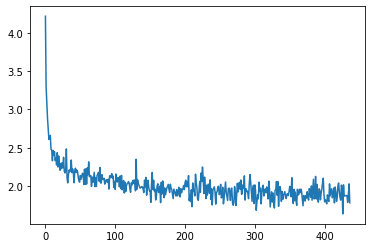

In [52]:
plt.figure()
plt.plot(record['loss'])
plt.show()

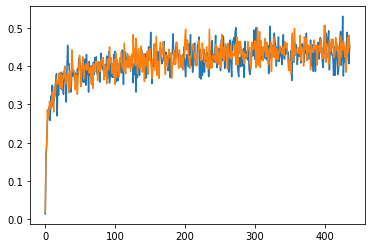

In [53]:
plt.figure()
plt.plot(record['trainAC'])
plt.plot(record['testAC'])
plt.show()

In [54]:
print(calc_accuracy(model, test_data, n_batch=len(test_data)-1, device=device))
print(calc_accuracy(model, train_data, n_batch=len(train_data)-1, device=device))

0.4441741108894348
0.4526556134223938


In [55]:
print(generate(model, device)) #default tau = 0.8

Juliet, you must hear 'tis thnibe not the told:
I hools this ither meet and my sare and rest offence of honestife.

MACHERCESTER:
Thrunce to the croct; the blains,
Which my deen, fave to of the gread, he was, have this sold yet mined will thy best and so these are or yet fures the canter my fair on the co


In [56]:
print(generate(model, device, seed='juliet', tau=0.1), '\n') #deterministic
print(generate(model, device, seed='juliet', tau=2), '\n') #radom

julieter the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the sha 

juliettort bud!

FEASMRIXATh.
Th, Fuclak!' ammazfy-hibjearogt:
Late haubence-prizRO hen, chree;
Getwu!-
r ciasoy,
'pbongue,
but tauavvestinluetanacuz
orss nhy a dosman,puce'tr,
Wuite every myoreyy,--f.
A fathty they: wemeaturad;
We'l-goatf,
To daule me:
Yude
dblr hung Kacffjur o' nexven ot lay did Brrie.
 



In [57]:
print(generate(model, device, seed='i will', predict_len=500, tau=0.8), '\n') 

i will.

IAGUR:
Why sleap the warress: and the vart.

BARDINANT:
Nay, sir, and for the commons him
Olay.

MERINS:
Nay, I will you, and what to the faephrainter 'traid are sid.

KING GROMATHELLEN:
Stean.

PERCOLIA:
Hellow in thanks ant are the surmscour that
If he see, the womants, 'eredier, what this desural he gure I may In the dead that you the his here's sear the cannot there to conceits balety, so blood here man the must father to be the regries fally seef from thy fast, I for not this creed may I 



In [58]:
random_train_seq(model, nptext, seq_len=200, device=device)

----------input data----------
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you
----------prediction----------
orst tatioen 
Tu ore tilwroveid tnd torther  ae rtty toeak 

CNl 
Toeak  aieak 

Cirst tatioen 
Tou sre t l teaendes tenher th tossthet th toiene 

CNl 
Tesendes 
Teaendes 

Cirst tatioen 
Torst  aou 


In [59]:
seeds = ["I", "Juliet", "KING:", "my lord", "flower", "soldier", "my son", "father", "hope", "death"]
for seed in seeds:
    print("------------seed: {}-----------".format(seed))
    print(generate(model, device, seed=seed, predict_len=500, tau=0.8))

------------seed: I-----------
I day made!

CADETRO:
You am in in the, libely as the trained
And here for this was him shall to comes our his a purcessed me it, I most come speinow
their are thou dalsal what, not majestoring the comes here brangee prace so office.

LUCIUS:
That be of your a seep
Lord Hence. Well
That you no may here grease, the this not when their thy connery in that the day out the would charge the heaven him! ame shall come you death not me to the heart
I heard is keep to their friends,
Upon and our but lams
------------seed: Juliet-----------
Julieter.

CLIUS:
Ware the guestoness from the laster,
A his to her ble to your goods prisent him us.

LAKEAR:
Shall-his more the annights
I am you meap not follows me that here ecenst a hear a gother doin.
The desered aman your been that thou mister,
In a sward, I know not spore not's the come and have here a swick
As a this dear it.

PORNIA:
That you bold.

LACYARK AFIO:
And good is beland,
And me wors, there a boot these my 